Data from https://datamarket.com/data/set/235d/mean-daily-temperature-fisher-river-near-dallas-jan-01-1988-to-dec-31-1991#!ds=235d&display=line

In [234]:
%matplotlib inline
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/steeks91/Data-Science-Portfolio/master/Data/mean-daily-temperature-fisher-ri.csv"
df = pd.read_csv(url, sep=";", names=["Date", "Mean daily temperature"], skiprows=1)

#Convert mean daily temperature to numeric
df["Mean daily temperature"] = df["Mean daily temperature"].str[1:]
df["Mean daily temperature"] = pd.to_numeric(df["Mean daily temperature"])

#Convert to datetime and set as index
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index('Date')

#Replace nan with mean
df = df.fillna(df.mean())

#Convert to series
df = df["Mean daily temperature"]

In [235]:
df.head()

Date
1988-01-01    23.0
1988-01-02    20.5
1988-01-03    22.0
1988-01-04    30.5
1988-01-05    31.0
Name: Mean daily temperature, dtype: float64

In [236]:
df.describe()

count    1461.000000
mean        8.504739
std         7.954452
min         0.000000
25%         2.500000
50%         6.500000
75%        11.250000
max        35.000000
Name: Mean daily temperature, dtype: float64

Text(0,0.5,'Temperature, C')

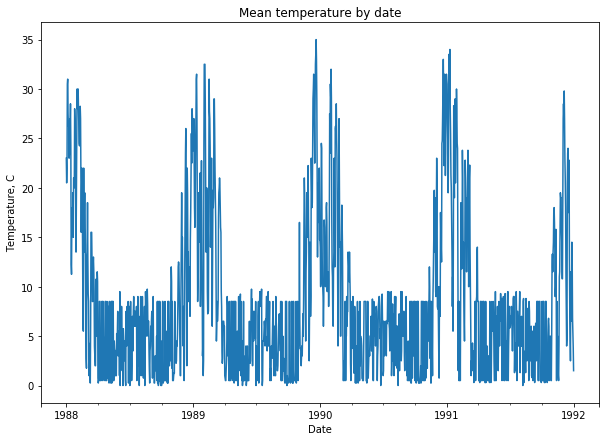

In [237]:
import matplotlib.pyplot as plt 
ax = df.plot(title="Mean temperature by date", figsize=(10,7))
ax.set_ylabel("Temperature, C")

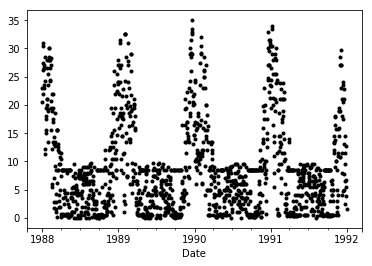

In [238]:
df.plot(style="k.")

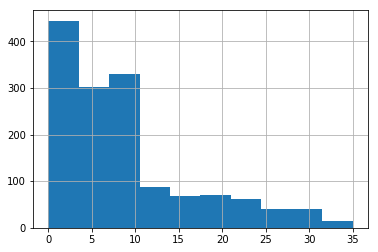

In [239]:
df.hist()

C:\Users\stefan.ekstrom\AppData\Local\Continuum\Anaconda3\envs\sasrev\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Mean daily temperature')

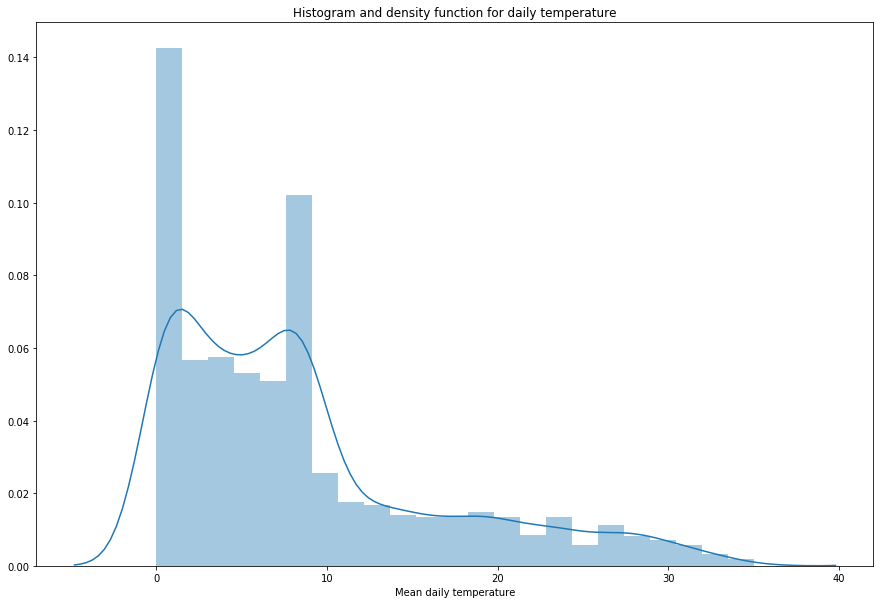

In [240]:
import seaborn as sns
fig = plt.figure(figsize=(15,10))
ax = sns.distplot(df, hist=True, kde=True)
ax.set_title("Histogram and density function for daily temperature")
ax.set_xlabel("Mean daily temperature")

Text(0.5,0,'Day Of Week')

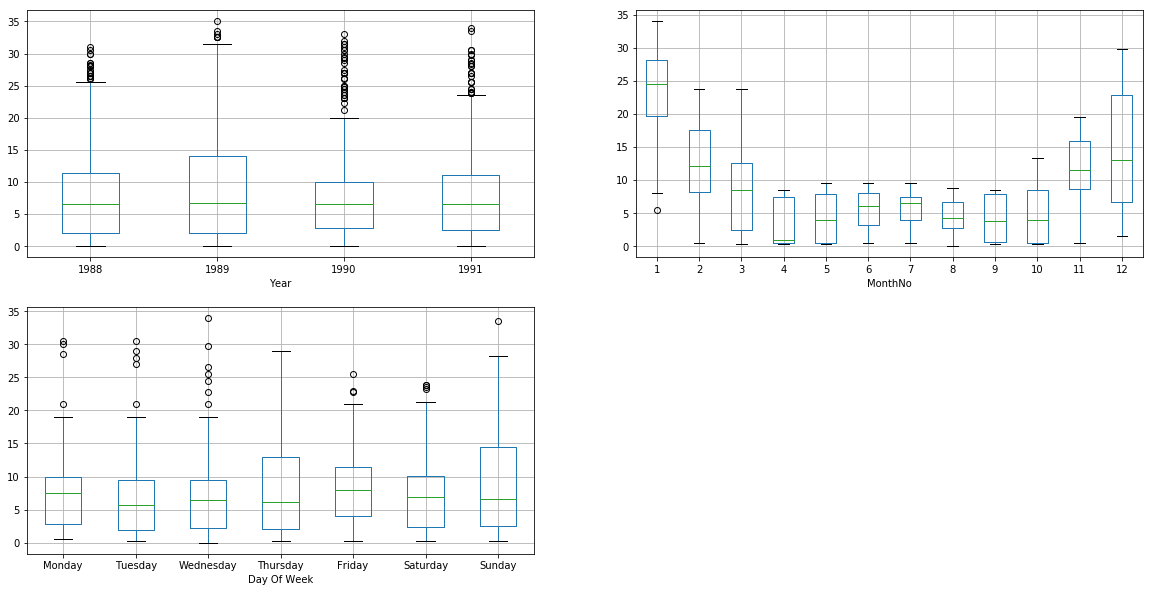

In [241]:
import calendar
from datetime import date
from dateutil.relativedelta import relativedelta
fig = plt.figure(figsize=(20,10))


####################Year#######################   
groups = df.groupby(pd.Grouper(freq="Y"))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = pd.Series(group.values)
    
plt.subplot(221)
ax = years.boxplot()
ax.set_xlabel("Year")


####################Months for Last Year#######################
#Select last year
last_year = max(df.index.year)
last_year = df[str(last_year)]

groups = last_year.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,13)

plt.subplot(222)
ax = months.boxplot()
ax.set_xlabel("MonthNo")


####################DayOfWeek#######################   
groups = last_year.groupby(last_year.index.weekday)
days = pd.DataFrame()
for name, group in groups:
    weekday = calendar.day_name[name]
    days[weekday] = pd.Series(group.values)

plt.subplot(223)
ax = days.boxplot()
ax.set_xlabel("Day Of Week")

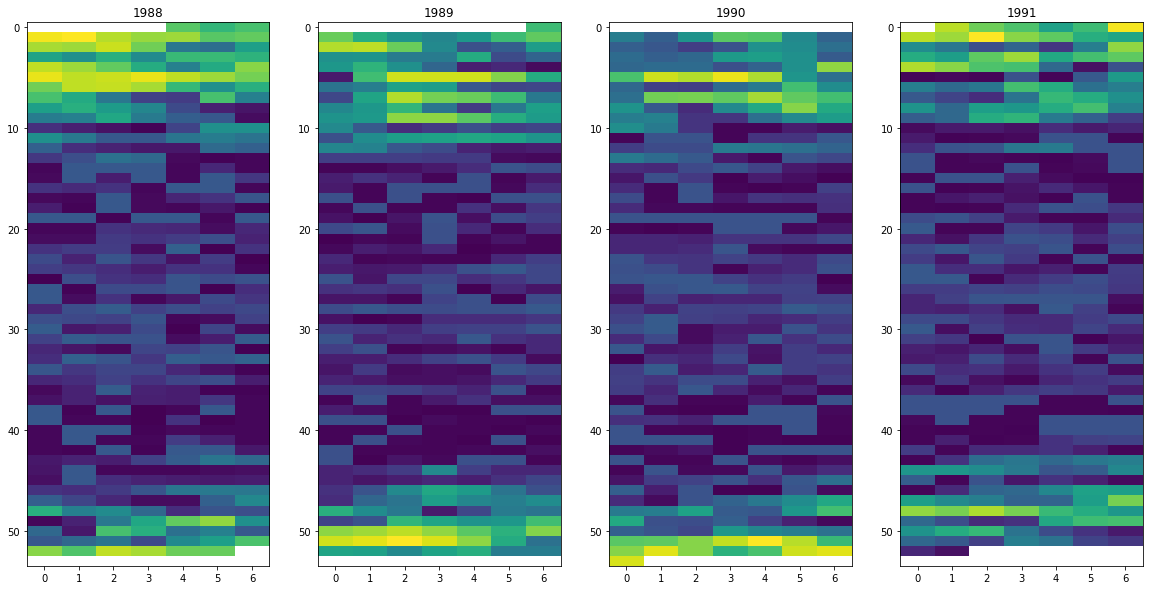

In [242]:
import datetime
#Display weekdays for each year
fig = plt.figure(figsize=(20,10))
num_year = max(df.index.year) - min(df.index.year)

for i in range(0, num_year+1):
    #Subset one year at a time
    last_date = max(df.index)
    selected_year = (last_date + relativedelta(years = -i)).year
    selected_year_data = df[str(selected_year)]
    
    #Group per weekday
    groups = selected_year_data.groupby(selected_year_data.index.weekday)
    days = pd.DataFrame(np.zeros(shape=(53,7)))

    #Create an empty first week 
    first_week = np.zeros(shape=(1,7))
    first_week[:] = np.nan
    first_week = pd.DataFrame(first_week)
    
    #Fill the values of the first week if they don't start on Monday
    for weekday, group in groups:

        #If the date of the first week is less than the weekday (zero-indexed) it means the year didn't start with a Monday
        #and should be added to first week
        if group[[0]].index.date[0].day < weekday + 1:
            first_week[weekday] = group.values[0]
            group = group[1:]
        
        
        days[weekday] = pd.Series(group.values)
    
    #if the year is not starting with the first of January, fill the first part of the year with NaN
    if min(selected_year_data.index) != datetime.datetime(selected_year, 1, 1):
        print(selected_year)
        no_weeks = len(days.dropna(thresh=1))
        temp = days[:no_weeks+1]
        days = pd.concat([days, temp])
        days = days[no_weeks+1:].reset_index(drop=True)
    
    else:    
        days = pd.concat([first_week, days]).reset_index(drop=True)
    
    ax = plt.subplot(1, 4, 4-i)
    plt.imshow(days, interpolation=None, aspect="auto")
    plt.title(selected_year)

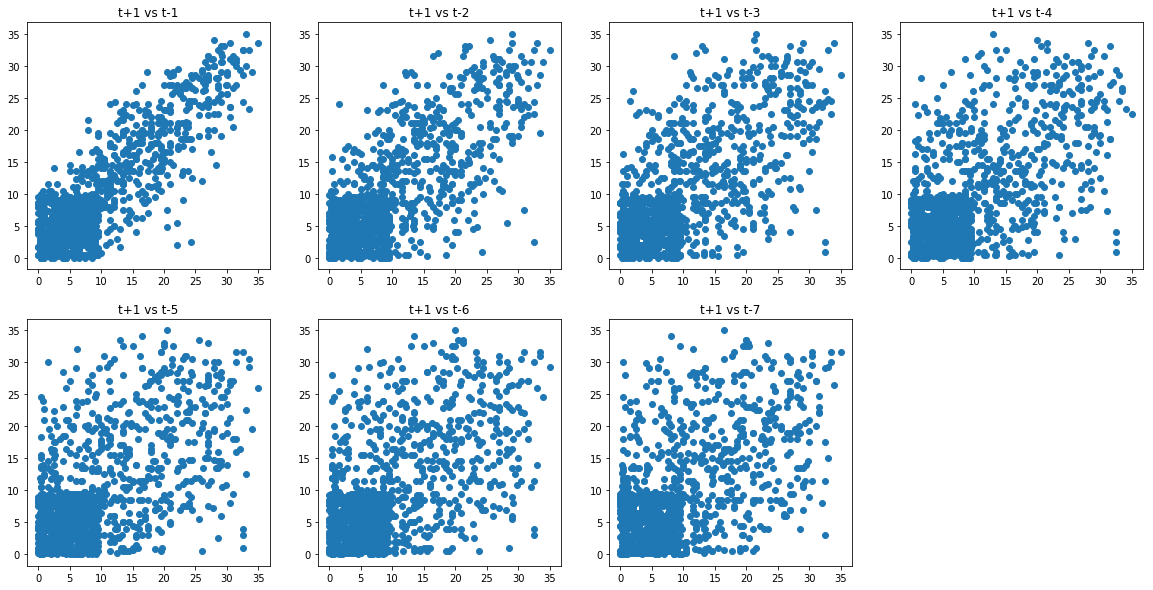

In [243]:
#Check relationship between a value and all the days during the last week
values = pd.DataFrame(df.values)
lags = 7
columns = [values]
for i in range(1, (lags + 1)):
    columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ["t+1"]
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
fig = plt.figure(figsize=(20,10))

for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)

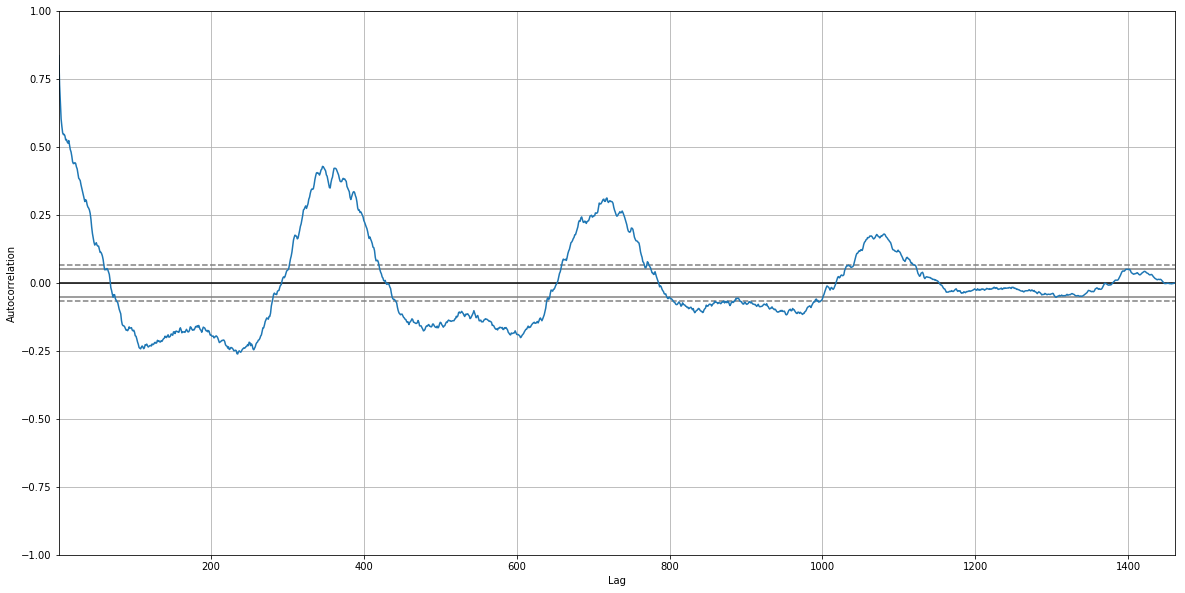

In [244]:
#Create an autocorrelation plot
from pandas.plotting import autocorrelation_plot
fig = plt.figure(figsize=(20,10))
autocorrelation_plot(df)

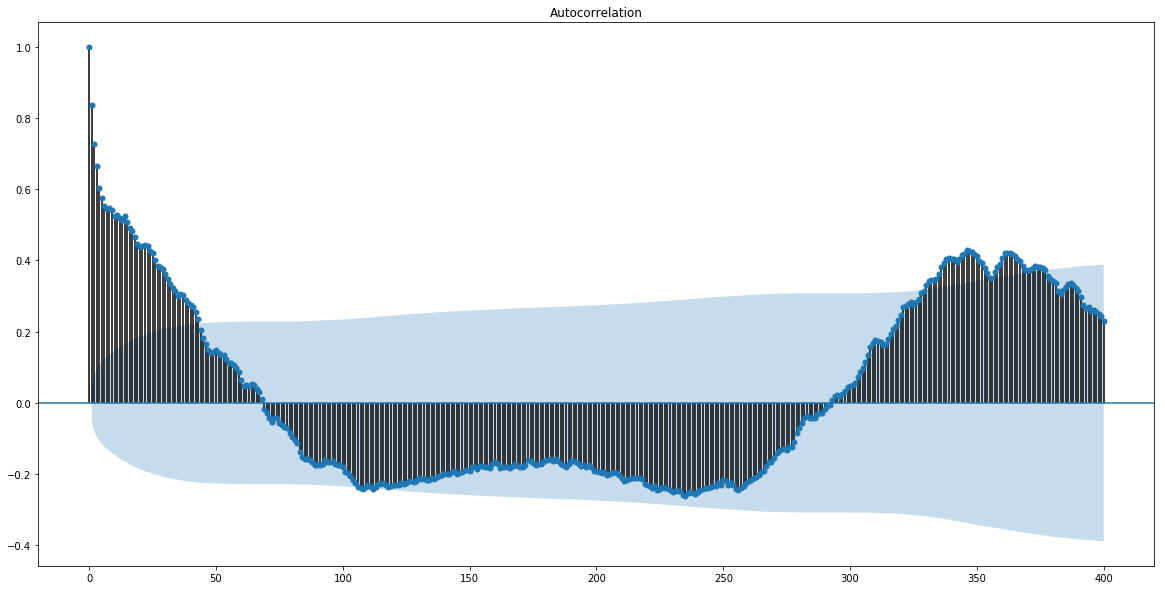

In [245]:
#Create an acf plot
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(df, lags=400, ax=ax)
plt.show()

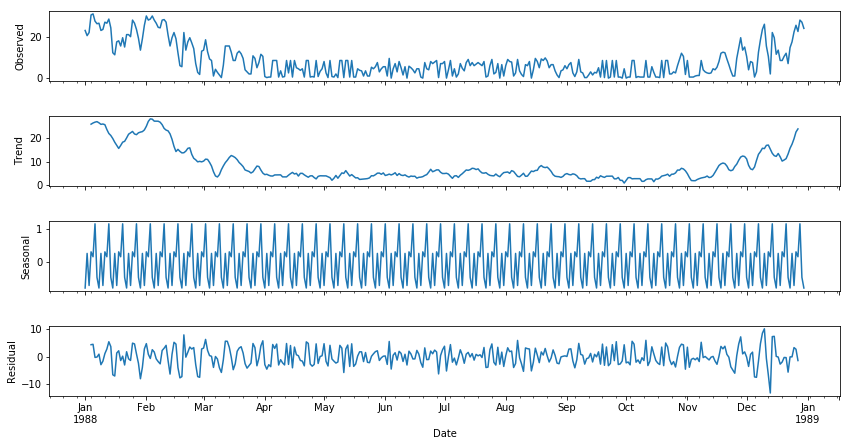

In [246]:
#Do a decomposition for one year 
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df[0:365], model="additive")
fig = result.plot()
fig.set_size_inches(13,7)

## Group on a month level to explore the data

In [249]:
##Group by month instead
df = df.resample("M").mean()
df.head()

Date
1988-01-31    22.137097
1988-02-29    19.025862
1988-03-31     8.596927
1988-04-30     3.843088
1988-05-31     3.904143
Freq: M, Name: Mean daily temperature, dtype: float64

In [253]:
df.describe()

count    48.000000
mean      8.531422
std       6.117952
min       2.605909
25%       4.013649
50%       5.443441
75%      12.115528
max      23.038710
Name: Mean daily temperature, dtype: float64

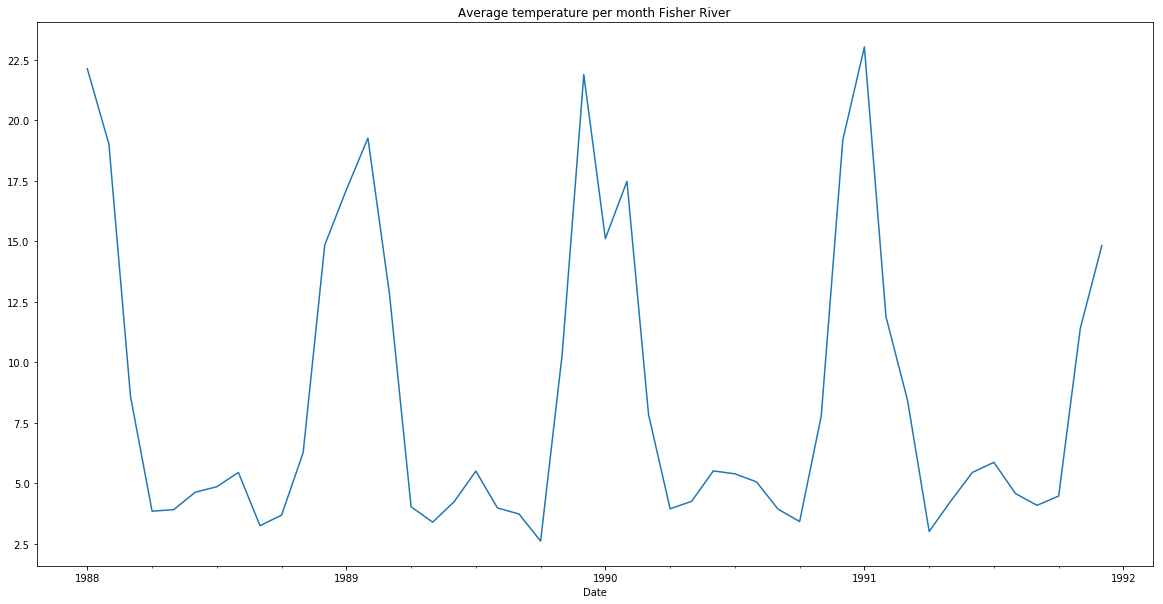

In [252]:
df.plot(figsize=(20,10), title="Average temperature per month Fisher River")

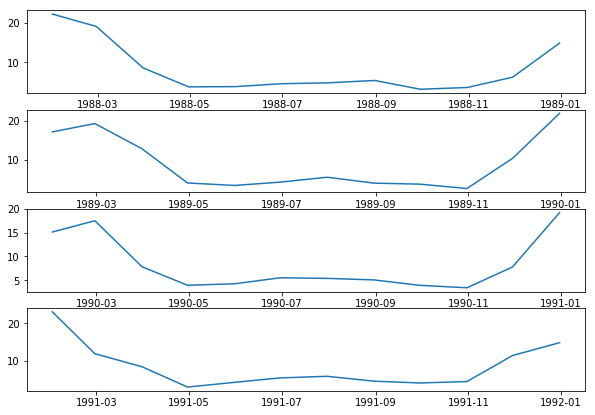

In [260]:
#Plot the years on top of each other to show yearly trends
groups = df.groupby(pd.Grouper(freq="A"))
fig = plt.figure(figsize=(10,7))
i = 1
n = len(groups)

for name, group in groups:
    plt.subplot((n*100)+10+i)
    plt.plot(group)
    i += 1

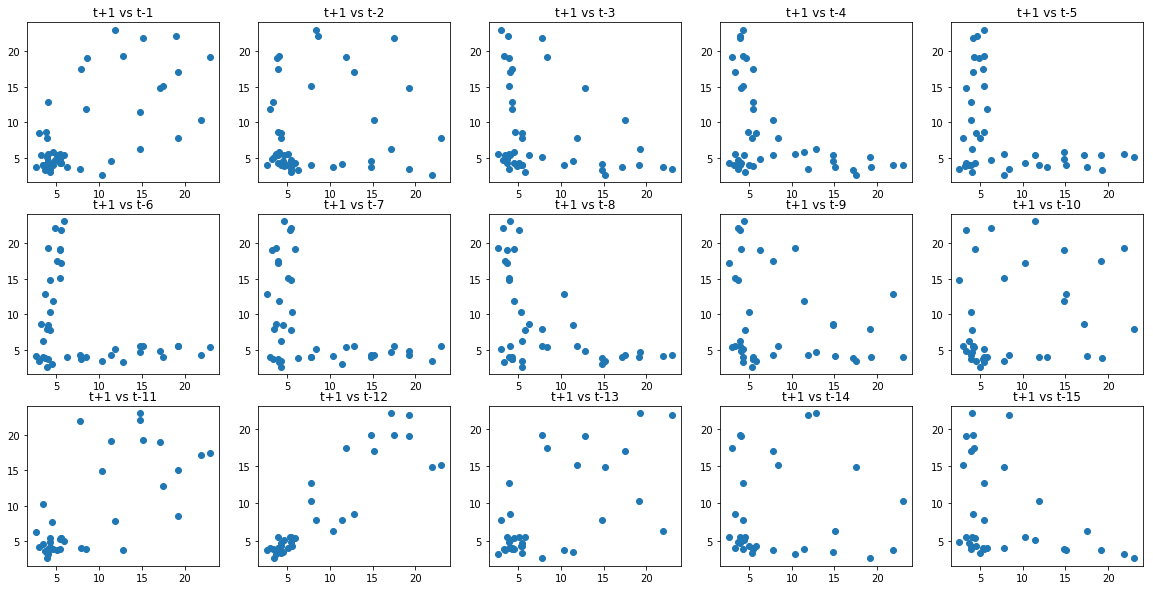

In [261]:
#Create a lag plot per month
values = pd.DataFrame(df.values)
lags = 15
columns = [values]
for i in range(1, (lags + 1)):
    columns.append(values.shift(i))
data = pd.concat(columns, axis=1)
columns = ["t+1"]
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
data.columns = columns
fig = plt.figure(figsize=(20,10))

for i in range(1,(lags + 1)):
    ax = plt.subplot(3,5,i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=data['t+1'].values, y=data['t-'+str(i)].values)

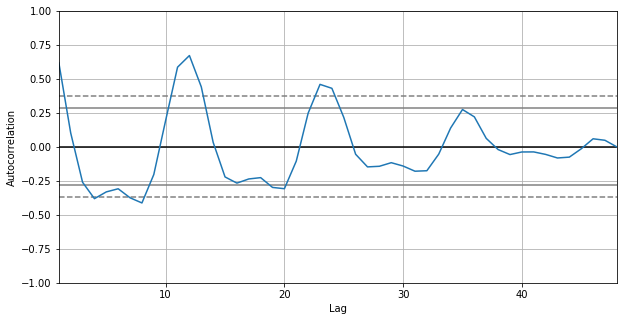

In [262]:
#Autocorrelation per month
from pandas.plotting import autocorrelation_plot
fig = plt.figure(figsize=(10,5))
autocorrelation_plot(df)